In [1]:
%config IPCompleter.greedy=True

In [2]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = 'https://www.minsal.cl/nuevo-coronavirus-2019-ncov/casos-confirmados-en-chile-covid-19/'
response = get(url)

In [4]:
html_soup = BeautifulSoup(response.text, 'html.parser')

In [5]:
#Almaceno los links de los archivos PDF
links = []
for table in html_soup.find_all('table'):
    for a in table.find_all('a'):
        links.append(a['href'])
    break

links

['https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-14-Casos-confirmados.pdf',
 'https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-13-Casos-Confirmados-Covid-19.pdf']

In [6]:
import requests

mypdf = requests.get(links[0])

In [7]:
import tabula

#Se extrae el pdf desde los links
df1 = tabula.read_pdf('https://www.minsal.cl/wp-content/uploads/2020/03/2020-03-14-Casos-confirmados.pdf', pages=1)    

Got stderr: mar 14, 2020 10:03:18 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
mar 14, 2020 10:03:18 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F2 are not implemented in PDFBox and will be ignored



In [8]:
df = df1[0]
len(df.index)

71

In [9]:
#Seteo columnas del DataFrame, se elimina la primera y última fila, por último se elimina la columna 'Casos confirmados'
df.columns = df.iloc[0].values
df = df.drop([0,len(df.index)-1]).reset_index(drop=True)
df = df.drop(['Casos confirmados'], axis=1)
df=df.rename(columns = {'Centro de salud':'Centro_salud'})
df.columns

Index(['Región', 'Sexo', 'Edad', 'Centro_salud'], dtype='object')

In [10]:
#Se normaliza la columna sexo y Centro_salud, por último se reemplazan por valores que lo preceden
df['Sexo'] = df['Sexo'].str.replace('Fememino','Femenino')
df['Centro_salud'] = df['Centro_salud'].str.replace('\r',' ')
df = df.fillna(method='ffill')

In [11]:
#Se eliminan filas que no tengan edad
df = df[df["Edad"]!='—'].reset_index(drop=True)

In [12]:
#Se transforma el formato de la columna Edad, de String a Entero
df['Edad'] = df['Edad'].astype(str).astype(int)

In [13]:
#Tabla final con todos los datos de contagios
df

,Región,Sexo,Edad,Centro_salud
0,Antofagasta,Femenino,58,Hospital Carlos Cisternas Calama
1,Antofagasta,Masculino,63,Hospital Carlos Cisternas Calama
2,Atacama,Masculino,50,Hospital de Copiapó
3,Metropolitana,Femenino,54,Clínica Alemana
4,Metropolitana,Femenino,40,Clínica Santa María
5,Metropolitana,Masculino,58,Clínica Alemana
6,Metropolitana,Masculino,17,Clínica Alemana
7,Metropolitana,Femenino,83,Clínica Las Condes
8,Metropolitana,Masculino,14,Clínica Alemana
9,Metropolitana,Masculino,42,Clínica U. de Los Andes


In [14]:
from datetime import datetime

#Exportamos los datos del día a CSV
df.to_csv(str(datetime.today().strftime('%d-%m-%Y')) + '.csv')

In [15]:
df1 = df.groupby('Región')['Región'].count().reset_index(name='Cantidad')

In [16]:
df1

,Región,Cantidad
0,Antofagasta,2
1,Atacama,1
2,Aysén,1
3,Biobío,3
4,Los Lagos,1
5,Maule,9
6,Metropolitana,39
7,Ñuble,4


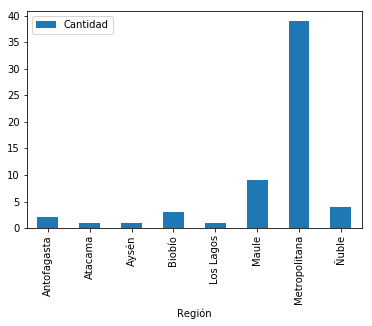

In [17]:
df1.plot(kind='bar',x='Región',y='Cantidad')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000002837453668>]],
      dtype=object)

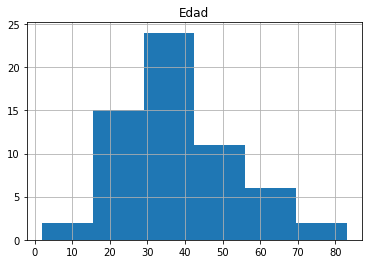

In [18]:
df.hist(bins=6)

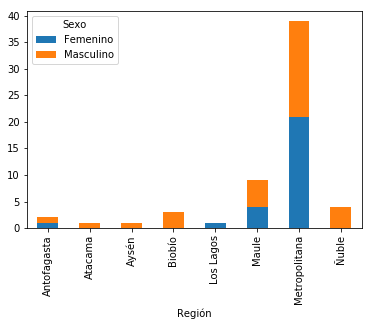

In [19]:
df.groupby(['Región','Sexo']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [20]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="Covid19-CL")
location = geolocator.geocode("Clínica Las Condes, Región Metropolitana, Chile")
print(location.address)
#Flatiron Building, 175, 5th Avenue, Flatiron, New York, NYC, New York, ...
print((location.latitude, location.longitude))
#(40.7410861, -73.9896297241625)
#print(location.raw)
#{'place_id': '9167009604', 'type': 'attraction', ...}

Clinica Las Condes, 450, Estoril, Las Condes, Provincia de Santiago, Región Metropolitana de Santiago, 7550000, Chile
(-33.3840374, -70.5309885140944)


In [21]:
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)
print(geocode("Clínica Las Condes, Región Metropolitana, Chile"))
df_loc = df
df_loc['Address'] = 'Región ' + df_loc['Región'] + ', Chile'
lat = []
lon = []
for index, row in df_loc.iterrows():
    location = geocode(row['Address'])
    lat.append(location.latitude)
    lon.append(location.longitude)
    print('Done!')
df_loc['lat'] = lat
df_loc['lon'] = lon
df_loc


Clinica Las Condes, 450, Estoril, Las Condes, Provincia de Santiago, Región Metropolitana de Santiago, 7550000, Chile
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Región Metropolitana, Chile',), **{}).
Traceback (most recent call last):
  File "C:\Users\DiegoEliezer\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\DiegoEliezer\Anaconda3\lib\urllib\request.py", line 1320, in do_open
    r = h.getresponse()
  File "C:\Users\DiegoEliezer\Anaconda3\lib\http\client.py", line 1321, in getresponse
    respon

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


,Región,Sexo,Edad,Centro_salud,Address,lat,lon
0,Antofagasta,Femenino,58,Hospital Carlos Cisternas Calama,"Región Antofagasta, Chile",-22.455864,-68.927458
1,Antofagasta,Masculino,63,Hospital Carlos Cisternas Calama,"Región Antofagasta, Chile",-22.455864,-68.927458
2,Atacama,Masculino,50,Hospital de Copiapó,"Región Atacama, Chile",-26.385295,-70.047757
3,Metropolitana,Femenino,54,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616
4,Metropolitana,Femenino,40,Clínica Santa María,"Región Metropolitana, Chile",-33.435442,-70.676616
5,Metropolitana,Masculino,58,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616
6,Metropolitana,Masculino,17,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616
7,Metropolitana,Femenino,83,Clínica Las Condes,"Región Metropolitana, Chile",-33.435442,-70.676616
8,Metropolitana,Masculino,14,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616
9,Metropolitana,Masculino,42,Clínica U. de Los Andes,"Región Metropolitana, Chile",-33.435442,-70.676616


In [22]:
import folium
from folium.plugins import MarkerCluster

map1 = folium.Map(
    location=[-35.675148,-71.5429688],
    tiles='OpenStreetMap',
    zoom_start=4.5,
)
mc = MarkerCluster()

for row in df_loc.itertuples():
    mc.add_child(folium.Marker(location=[row.lat, row.lon], popup=folium.Popup('Edad: ' + str(row.Edad) + ' ' + row.Sexo + '  (' + row.Centro_salud + ')', max_width=90)))
mc.add_to(map1)
map1
#folium.CircleMarker(location= [location.latitude, location.longitude]).add_to(map1)
#df.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
#df_loc.apply(lambda row:folium.Marker(location=[row['lat'], row['lon']], popup = row['Edad']).add_to(map1), axis=1)
#map1

In [24]:
#El mapa se exporta a HTML
map1.save('Mapa-Covid19-CL.html')